# Random Forest Model

After trying to optimize the logistic regression model and not being able to improve results, I decided a random forest classifier would be potentially more powerful than logistic regression but not as computationally expensive as an artificial neural network or support vector machine.

__Imports__

In [1]:
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

style.use('fivethirtyeight')
# import jupyterthemes as jt
# context = jt.jtplot.set_context('poster')
# jt.jtplot.set_style(context, 'monokai', ticks=True, spines=True)
# jt.stylefx.style_layout('nb_style', theme='monokai',
#                         toolbar=True, nbname=True, cellwidth='1000')
# jt.stylefx.set_nb_theme('monokai')


## Read in the data and instantiate models

In [2]:
df = pd.read_csv("../data/device_failure_data_scientist.csv")
df.head()

,date,device,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,failure
0,15001,S1F01085,215630672,56,0,52,6,407438,0,0,7,0
1,15001,S1F0166B,61370680,0,3,0,6,403174,0,0,0,0
2,15001,S1F01E6Y,173295968,0,0,0,12,237394,0,0,0,0
3,15001,S1F01JE0,79694024,0,0,0,6,410186,0,0,0,0
4,15001,S1F01R2B,135970480,0,0,0,15,313173,0,0,3,0


In [3]:
features = df.drop(columns=['date', 'device', 'failure'])
labels = df['failure']

In [4]:
X = features
y = labels

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    shuffle=False)

In [5]:
ss = StandardScaler()

X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

In [6]:
rf = RandomForestClassifier(max_depth=None,
                            n_estimators=15,
                            max_features=None,
                            min_samples_leaf=450,
                            n_jobs=-1,
                            random_state=42,
                            class_weight='balanced_subsample')

rf.fit(X_train_ss, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
                       criterion='gini', max_depth=None, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=450,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=15, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

## Model Evaluation

In [7]:
rf.score(X_train_ss, y_train)

0.9470600835386098

In [8]:
rf.score(X_test_ss, y_test)

0.9599987148181468

In [9]:
preds = rf.predict(X_test_ss)

# Generate confusion matrix.
confusion_matrix(y_test, preds)

array([[29861,  1237],
       [    8,    18]], dtype=int64)

In [10]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# Specificity and Sensitivity

spec = tn / (tn + fp)
sens = tp / (tp + fn)

print(f'Specificity: {round(spec, 4)}')
print(f'Sensitivity: {round(sens, 4)}')

Specificity: 0.9602
Sensitivity: 0.6923


### Outcome Distribution and ROC AUC 

In [11]:
# Pred data frame
pred_proba = [i[1] for i in rf.predict_proba(X_test_ss)]
pred_df = pd.DataFrame({'true_values': y_test, 'pred_probs': pred_proba})

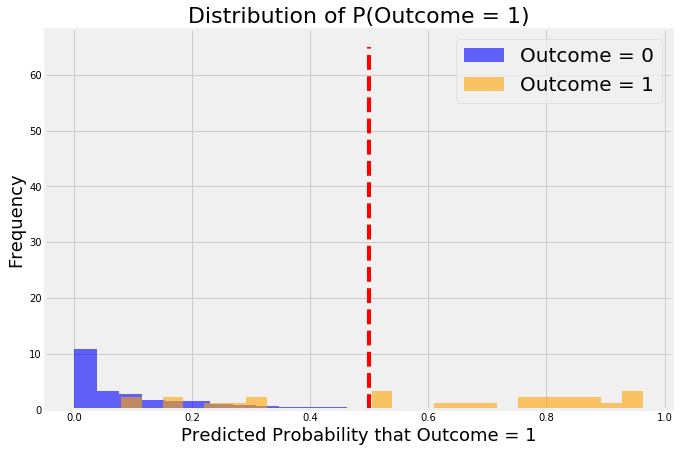

In [12]:
# Outcome Distribution
plt.figure(figsize=(10, 7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha=0.6,
         label='Outcome = 0',
         density=True)

plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha=0.6,
         label='Outcome = 1',
         density=True)

# Threshold
plt.vlines(x=0.5, ymin=0, ymax=65, color='r', linestyle='--')

plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)
plt.legend(fontsize=20)

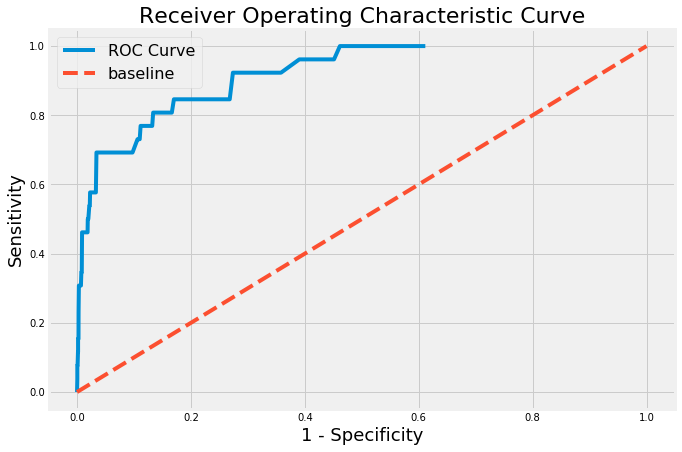

In [13]:
# ROC Curve
plt.figure(figsize=(10, 7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)


# Define function to calculate sensitivity.
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1)
                       & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1)
                        & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)


# Define function to calculate 1 - specificity.
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0)
                       & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0)
                        & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))


# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [
    TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds
]
fpr_values = [
    FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds
]

# Plot ROC curve.
plt.plot(
    fpr_values,  # False Positive Rate on X-axis
    tpr_values,  # True Positive Rate on Y-axis
    label='ROC Curve')

# Plot baseline.
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)
plt.legend(fontsize=16)

In [14]:
roc_auc_score(pred_df['true_values'], pred_df['pred_probs'])

0.9194463408480388

## Results

After some parameter tuning, the `RandomForestClassifier`significantly improved on the logistic regression.  The default `max_features` is the square root of the number of features however there are already so few features that it doesn't make sense to use less than the 9 at any given node.  After changing the `max_features` to include all of them, the model was much better at being able to predict failure. It is interesting to note that this used all the features instead of only the few from logistic regression that produced the best result.  Moving forward and ensemble with the logistic regression or more complicated models such as support vector machine or a neural network could further optimize results.  

In [15]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     31098
           1       0.01      0.69      0.03        26

    accuracy                           0.96     31124
   macro avg       0.51      0.83      0.50     31124
weighted avg       1.00      0.96      0.98     31124

